# 02 — Monte Carlo (MC): uczenie z pełnych epizodów

MC nie potrzebuje modelu $P$.  
Uczy się z trajektorii i czeka na **pełny zwrot** $G_t$ (do końca epizodu).


- *MC nie robi bootstrappingu* — nie używa własnych przewidywań $V(s')$, tylko prawdziwy „koniec historii”.

W tym notebooku:
1) MC prediction: $V^\pi$ dla ustalonej polityki,  
2) MC control: $Q(s,a)$ + ε-greedy (first-visit).


In [1]:
import os, sys
# dodaj katalog główny repo do ścieżki importów
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from envs.wrappers import get_spec
from envs.frozenlake import FROZENLAKE_MAPS, build_frozenlake_P, find_start_state, PModelEnv

from algorithms.mc import mc_prediction, mc_control_epsilon_greedy
from algorithms.dp import policy_evaluation
from algorithms.utils import plot_value_heatmap, plot_learning_curve

## Wybór środowiska

In [3]:
# FrozenLake-only (trzymamy spójność z 00/01)
# TODO (student): zmień mapę na "8x8" i zobacz jak rośnie trudność (więcej stanów + dłuższe epizody).
MAP_NAME = "8x8"   # "4x4" albo "8x8"

# TODO (student): ustaw SLIPPERY=False i porównaj z True.
SLIPPERY = True

desc = FROZENLAKE_MAPS[MAP_NAME]

# Budujemy jawny model P[s][a] (ten sam, którego DP używa do "prawdy").
P, nS, nA, nrow, ncol, desc_arr = build_frozenlake_P(desc, is_slippery=SLIPPERY)

# TODO (student): znajdź start 'S' (dla map niestandardowych to ważne).
s0 = find_start_state(desc_arr)  # rozwiązanie

env = PModelEnv(P, start_state=s0, seed=0, desc=desc_arr)
env.nrow, env.ncol, env.desc = nrow, ncol, desc_arr

spec = get_spec(env, gamma=0.99)
print("FrozenLake map:")
print("\n".join("".join(row) for row in spec.desc))
spec


FrozenLake map:
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


DiscreteEnvSpec(nS=64, nA=4, shape=(8, 8), terminals={35, 41, 42, 46, 49, 19, 52, 54, 59, 29, 63}, gamma=0.99, desc=array([['S', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
       ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
       ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'],
       ['F', 'F', 'F', 'F', 'F', 'H', 'F', 'F'],
       ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'F'],
       ['F', 'H', 'H', 'F', 'F', 'F', 'H', 'F'],
       ['F', 'H', 'F', 'F', 'H', 'F', 'H', 'F'],
       ['F', 'F', 'F', 'H', 'F', 'F', 'F', 'G']], dtype='<U1'))

### Model `P[s][a]` i generator doświadczeń

W tym kursie trzymamy się jednej, bardzo prostej konwencji:

$$
P[s][a] = \{(p, s', r, done), \dots\}
$$

- **DP** (model-based) robi *backup* przez wartość oczekiwaną: sumuje po wszystkich `(p, s', r, done)` z `P[s][a]`.
- **MC/TD** (model-free) potrzebują *danych*, więc musimy wygenerować trajektorie.

Dlatego dla FrozenLake budujemy najpierw `P[s][a]` funkcją `build_frozenlake_P(...)`,
a potem opakowujemy to w `PModelEnv`, gdzie `step(a)` **losuje jedno przejście** zgodnie z prawdopodobieństwami `p`.

> Ten zabieg jest mega dydaktyczny: **DP i MC/TD pracują na tym samym świecie**, tylko używają go inaczej.

### Most z DP (Ch05_01) do MC (ten notebook)

W **00** widzieliśmy, że `step(a)` zwraca pojedynczą próbkę z rozkładu `P[s][a]`.  
W **01** policzyliśmy $V^\pi$ i $V^*$ „z definicji”, sumując po wszystkich outcomes z modelu.

Teraz robimy krok do **model-free**:

- **MC nie używa modelu** $P(s'|s,a)$ do uczenia — korzysta tylko z trajektorii $(s_t,a_t,r_{t+1})$ generowanych przez `env.step`.
- Target w MC to **pełny zwrot** (do końca epizodu):
  $$G_t = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k+1}.$$
- (Opcjonalnie) jeśli mamy `P`, policzymy DP-baseline $V^\pi$ tylko po to, żeby móc narysować błąd/MSE i porównać metody.


## 1) MC prediction: V^π dla polityki losowej

Najpierw ustalamy politykę π (tu: losową).  
Jeśli środowisko ma model `P`, policzymy DP-baseline, żeby mieć „prawdę” do MSE.


### Intuicja z DP (Ch05_01), która wraca w MC (Ch05_02): „dyfuzja” informacji o nagrodzie

W Ch05_01 (DP / value iteration) widzieliśmy, że zaczynając od $V_0=0$ i wykonując kolejne backupy Bellmana, informacja o nagrodzie “rozlewa się” od celu po całej planszy.  
To działa szybko, bo DP ma pełny model $P[s][a]$ i w każdej iteracji uwzględnia **wszystkie** możliwe następstwa.

W Ch05_02 (Monte Carlo) też zobaczymy, że wartości z czasem “pojawiają się” coraz dalej od celu, ale mechanizm jest inny:
- MC nie ma $P[s][a]$, więc uczy się wyłącznie z trajektorii z `step()`,
- “dyfuzja” zachodzi tylko przez **odwiedzane stany**,
- dlatego warto patrzeć nie tylko na heatmapę $V(s)$, ale też na heatmapę liczby odwiedzin (coverage), bo bez odwiedzin nie ma czego estymować.

Krótko: **DP rozlewa wartość przez model, MC rozlewa wartość przez doświadczenie.**


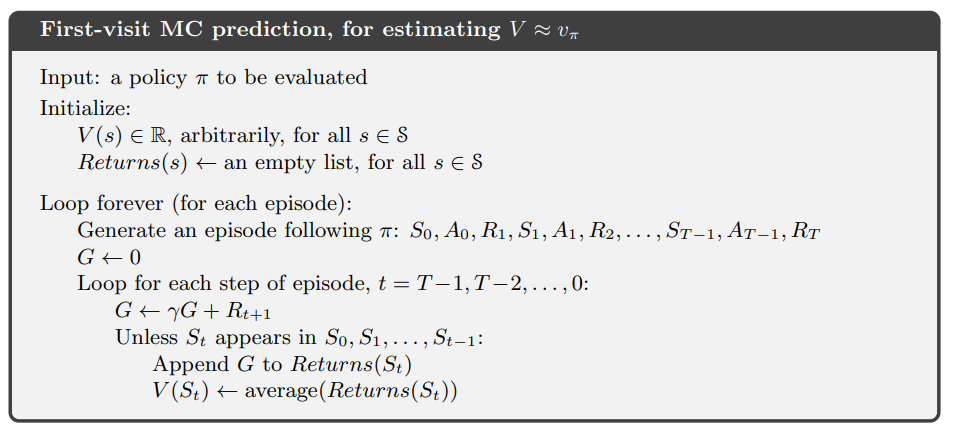

## Monte Carlo prediction (first-visit): estymacja $V^\pi$

W DP (01) mieliśmy model $P[s][a]$ i liczyliśmy wartości przez wartość oczekiwaną “po wszystkich outcomes”.
W MC przechodzimy na model-free: **nie używamy $P[s][a]$ w aktualizacji**, tylko trajektorie z `step()`.

### Co estymujemy?
Dla ustalonej polityki $\pi$ chcemy policzyć:

$$
V^\pi(s)=\mathbb{E}_\pi[G_t \mid S_t=s],
$$

gdzie zwrot (return) to:

$$
G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \dots
$$

### First-visit MC (intuicja)
W jednym epizodzie stan może pojawić się wiele razy.
W wersji **first-visit** aktualizujemy $V(s)$ tylko przy pierwszym wystąpieniu stanu $s$ w danym epizodzie.  
To odpowiada klasycznemu pseudokodowi “Unless $S_t$ appears earlier in the episode”.

### Jak aktualizujemy $V(s)$ bez trzymania listy Returns?
Zamiast przechowywać listy `Returns(s)` (jak w książce), robimy inkrementalną średnią.
Jeśli $N(s)$ to licznik aktualizacji, a nowa próbka zwrotu to $G$, to:

$$
V(s) \leftarrow V(s) + \frac{G - V(s)}{N(s)}.
$$

To jest równoważne liczeniu średniej, ale jest prostsze i oszczędza pamięć.


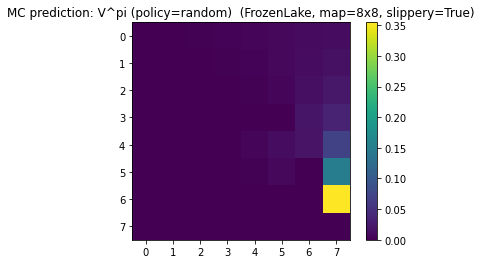

MSE do DP baseline: 0.0027720185556108336


In [4]:
rng = np.random.default_rng(0)

# TODO: napisz politykę losową π, która zwraca akcję z {0,...,nA-1}.
# W MC prediction to jest "ustalona polityka", nie uczymy jej jeszcze.
def random_policy(s):
    # TODO skorzystaj z integers wzgledem możliwych akcji spec.nA:
    return int(rng.integers(0, spec.nA)) 

# DP baseline (jeśli mamy model P) — to będzie "prawda" do porównań.
V_dp = None
if hasattr(env, "P"):
    P_model = env.P
    pi_random = np.ones((spec.nS, spec.nA), dtype=np.float64) / spec.nA
    V_dp = policy_evaluation(P_model, pi_random, gamma=spec.gamma)

# MC prediction
V_mc, N_vis = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=50_000)

plot_value_heatmap(V_mc, spec.shape, title=f"MC prediction: V^pi (policy=random)  (FrozenLake, map={MAP_NAME}, slippery={SLIPPERY})")

if V_dp is not None:
    mse = float(np.mean((V_mc - V_dp)**2))
    print("MSE do DP baseline:", mse)

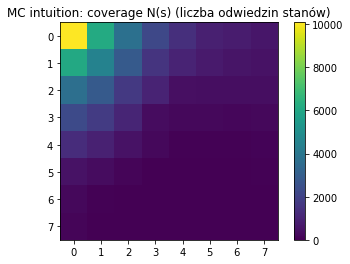

In [5]:
# ============================================================
# Coverage: heatmapa liczby odwiedzin N(s) pod tą samą polityką π (dla intuicji MC)
# ============================================================
# TODO: Zwiększ liczbę epizodów i zobacz jak coverage się wyrównuje.
# TODO: Porównaj SLIPPERY=False vs SLIPPERY=True (coverage zwykle "rozmywa się").
# TODO: Zmień politykę (np. bardziej "celową") i zobacz jak zmienia się coverage.

import numpy as np

def estimate_state_visits(env, pi, n_episodes=1, max_steps=10_000):
    nS = spec.nS
    visits = np.zeros(nS, dtype=np.int64)

    for _ in range(n_episodes):
        s, _ = env.reset()
        visits[int(s)] += 1
        for _ in range(max_steps):
            a = np.random.choice(spec.nA, p=pi[int(s)])
            s, r, terminated, truncated, _ = env.step(a)
            visits[int(s)] += 1
            if terminated or truncated:
                break
    return visits

# polityka π: zakładam, że masz pi_random (np. tablica [nS,nA]) albo potrafisz ją zbudować
# Jeśli w MC prediction używałeś funkcji policy(s)->dist, to zamień na tablicę pi[s].
try:
    pi_used = pi_random
except NameError:
    # fallback: losowa polityka
    pi_used = np.ones((spec.nS, spec.nA), dtype=float) / spec.nA

N_vis = estimate_state_visits(env, pi_used, n_episodes=2000)
#TODO można sprawdzić sobie różne skale liniowa/logarytmiczna
plot_value_heatmap(N_vis.astype(float), spec.shape, title="MC intuition: coverage N(s) (liczba odwiedzin stanów)")
#plot_value_heatmap(np.log1p(N_vis.astype(float)), spec.shape,title="Coverage: log(1+N(s))")


Uwaga: liczniki `N` w MC (first-visit) nie muszą być tym samym co “liczba kroków spędzonych w stanie” — to inna definicja odwiedzin.


## 2) Zbieżność MC: wariancja na małej liczbie epizodów

Tu warto zwrócić uwagę, że MC potrzebuje wielu epizodów, żeby mapa „wygładziła się”.


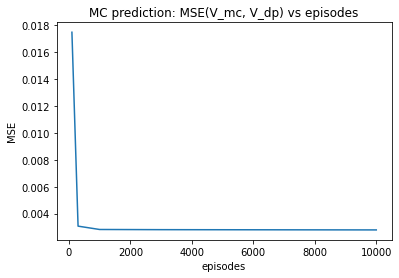

In [6]:
EP_LIST = [100, 300, 1_000, 3_000, 10_000]
mses = []
for E in EP_LIST:
    V_mc_E, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=E)
    if V_dp is not None:
        mses.append(float(np.mean((V_mc_E - V_dp)**2)))

if V_dp is not None:
    plot_learning_curve(EP_LIST, mses, title="MC prediction: MSE(V_mc, V_dp) vs episodes", xlabel="episodes", ylabel="MSE")
else:
    print("Brak DP baseline: w tym notebooku to tylko opcjonalny punkt odniesienia (MSE).")

## 3) MC control: uczymy Q i politykę ε-greedy

To nadal MC, tylko zamiast V(s) uczymy Q(s,a) i poprawiamy politykę.

**Klik:**  
- MC control poprawia politykę na bazie *pełnych* zwrotów — wolniej, ale „bez biasu” bootstrappingu.


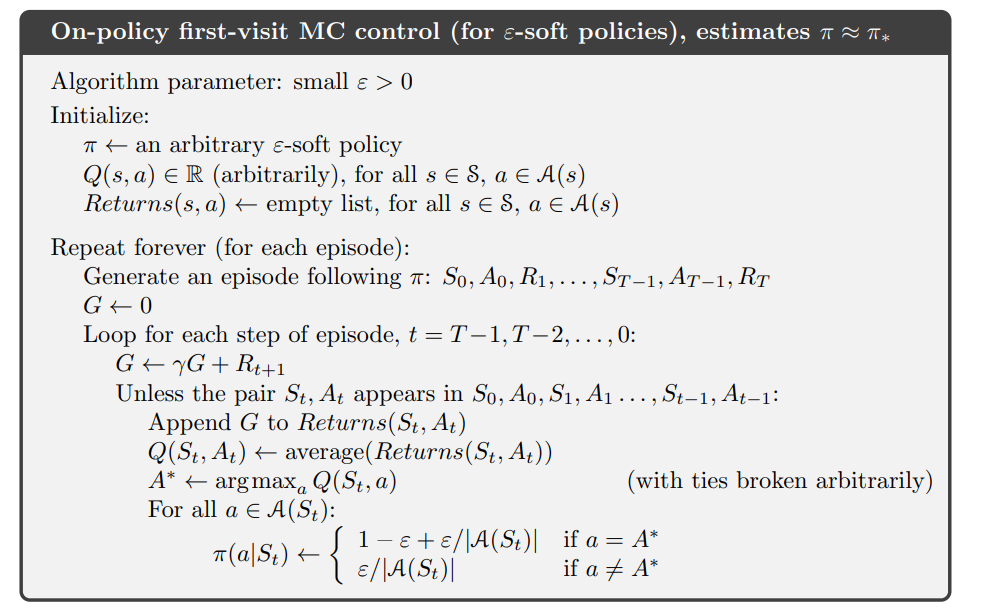

## Monte Carlo control: po co $Q(s,a)$?

W prediction estymujemy $V^\pi(s)$ dla ustalonej polityki — to jest **ocena** (evaluation).

W control chcemy też **poprawiać politykę**. Do tego wygodniej jest używać funkcji wartości akcji:

$$
Q^\pi(s,a)=\mathbb{E}_\pi[G_t \mid S_t=s,\ A_t=a].
$$

Dlaczego to ułatwia “improvement”?
Bo mając $Q(s,a)$ możemy wybrać najlepszą akcję w stanie:

$$
\pi_{\text{greedy}}(s) = \arg\max_a Q(s,a).
$$

Właśnie dlatego w MC control uczymy tablicę $Q[s,a]$, a dopiero potem z niej wyciągamy politykę.


## $\epsilon$-greedy jako implementacja $\epsilon$-soft policy (praktyczny skrót)

W książkowym pseudokodzie on-policy MC control polityka $\pi$ jest **$\epsilon$-soft**:
dla stanu $s$ i najlepszej akcji $A^*(s)=\arg\max_a Q(s,a)$:

$$
\pi(a\mid s)=
\begin{cases}
1-\epsilon+\epsilon/|A(s)| & \text{gdy } a=A^*(s), \\
\epsilon/|A(s)| & \text{gdy } a\neq A^*(s).
\end{cases}
$$

To zapewnia eksplorację: każda akcja ma dodatnie prawdopodobieństwo.

### Jak to robimy w implementacji (bez trzymania całej tablicy $\pi(a|s)$)?
Nie musimy jawnie przechowywać $\pi(a|s)$.
Zamiast tego “realizujemy” politykę przez funkcję wyboru akcji:

- z prawdopodobieństwem $1-\epsilon$ wybieramy akcję zachłanną $\arg\max_a Q(s,a)$,
- z prawdopodobieństwem $\epsilon$ wybieramy akcję losową z $\{0,\dots,nA-1\}$.

To jest równoważne $\epsilon$-soft policy, ale prostsze w kodzie:
- nie aktualizujemy jawnie rozkładów $\pi(\cdot|s)$ po każdym kroku,
- wystarczy aktualizować $Q$ i zawsze wybierać akcje przez `epsilon_greedy(Q[s], epsilon)`.

Ważne: to nadal jest **on-policy**, bo epizody generujemy aktualną polityką $\pi$ (tu: $\epsilon$-greedy względem aktualnego $Q$).


**Relacje między $V^\pi$ i $Q^\pi$**

Jeśli znamy $Q^\pi(s,a)$, to wartość stanu jest średnią ważoną po akcjach polityki:

$$
V^\pi(s)=\sum_a \pi(a\mid s)\,Q^\pi(s,a).
$$


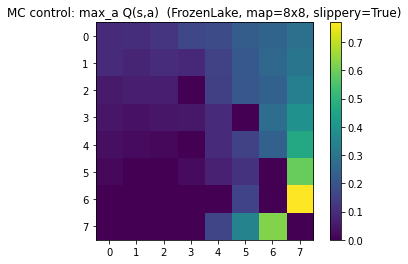

Greedy actions (pierwsze 8 stanów): [2 3 2 3 3 2 2 2]


In [7]:
Q, pi_greedy, N = mc_control_epsilon_greedy(env, nS=spec.nS, nA=spec.nA,
                                           gamma=spec.gamma, episodes=50_000,
                                           epsilon=0.1, seed=0)

V_from_Q = np.max(Q, axis=1)
plot_value_heatmap(V_from_Q, spec.shape, title=f"MC control: max_a Q(s,a)  (FrozenLake, map={MAP_NAME}, slippery={SLIPPERY})")
print("Greedy actions (pierwsze 8 stanów):", pi_greedy[:8])

### Dlaczego MC control wygląda podobnie do prediction?

Szkielet jest podobny:
1) generujemy epizod,
2) liczymy zwroty $G_t$,
3) uśredniamy zwroty.

Różnice są dwie:
- uczymy $Q(s,a)$ zamiast $V(s)$,
- polityka używana do generowania epizodu zależy od aktualnego $Q$ (GPI: evaluation + improvement w pętli).

### Reverse pass (liczenie $G$ od końca)
W implementacji często liczymy zwrot w jednym przebiegu od końca:

$$
G \leftarrow r + \gamma G,
$$

idąc po trajektorii od końca do początku. To jest równoważne wyznaczeniu wszystkich $G_t$ “do przodu”, tylko wygodniejsze w kodzie.

### First-visit dla pary $(s,a)$
W MC control first-visit dotyczy pary $(s,a)$:
aktualizujemy $Q(s,a)$ tylko dla pierwszego wystąpienia tej pary w epizodzie.


# DEMOs

## Demo 1: Czy polityka naprawdę działa?

Po MC control mamy tablicę `Q(s,a)`. Z niej wyciągamy politykę zachłanną:

- `pi_greedy[s] = argmax_a Q(s,a)`.

W tym demo robimy **test jakości**: uruchamiamy wiele epizodów, ale już bez eksploracji (czyli zawsze wybieramy akcję z `pi_greedy`) i mierzymy:

- `success_rate`: jaki % epizodów kończy się w celu,
- `avg_return`: średni zwrot (w FrozenLake zwykle ≈ success_rate, bo nagroda jest 0/1),
- `avg_steps`: jak długo średnio trwa epizod (czy agent krąży czy idzie “pewnie”).

Dodatkowo wypisujemy politykę jako strzałki, żeby zobaczyć, czy “logika” przejść zgadza się z intuicją na planszy.


In [8]:
import numpy as np

# jeśli nie masz jeszcze Q/pi_greedy (np. uruchamiasz tę komórkę osobno), to trenujemy szybki model:
try:
    Q, pi_greedy, N
except NameError:
    Q, pi_greedy, N = mc_control_epsilon_greedy(
        env, nS=spec.nS, nA=spec.nA,
        gamma=spec.gamma, episodes=50_000,
        epsilon=0.1, seed=0
    )

ACTION_CHARS = {0: "←", 1: "↓", 2: "→", 3: "↑"}

def evaluate_greedy_policy(env, pi_greedy, n_episodes=2000, max_steps=10_000):
    returns = []
    lengths = []
    successes = 0

    for _ in range(n_episodes):
        s, _ = env.reset()
        G = 0.0
        steps = 0
        for _ in range(max_steps):
            a = int(pi_greedy[int(s)])
            s, r, terminated, truncated, _ = env.step(a)
            G += float(r)
            steps += 1
            if terminated or truncated:
                break
        returns.append(G)
        lengths.append(steps)
        if G > 0.0:
            successes += 1

    return {
        "success_rate": successes / n_episodes,
        "avg_return": float(np.mean(returns)),
        "avg_steps": float(np.mean(lengths)),
        "returns": np.array(returns),
        "lengths": np.array(lengths),
    }

metrics = evaluate_greedy_policy(env, pi_greedy, n_episodes=2000)

print(f"MC control greedy eval | map={MAP_NAME} slippery={SLIPPERY}")
print(f"success_rate = {metrics['success_rate']:.3f}")
print(f"avg_return   = {metrics['avg_return']:.3f}")
print(f"avg_steps    = {metrics['avg_steps']:.1f}")

# wizualizacja polityki jako strzałki na siatce
desc_grid = np.array(spec.desc, dtype=str)  # 'S','F','H','G'
H, W = spec.shape
pol_grid = np.full((H, W), " ", dtype=object)

for s in range(spec.nS):
    r = s // W
    c = s % W
    cell = desc_grid[r, c]
    if cell in ["H", "G"]:
        pol_grid[r, c] = cell
    else:
        pol_grid[r, c] = ACTION_CHARS[int(pi_greedy[s])]

print("\nPolityka greedy (strzałki):")
for r in range(H):
    print(" ".join(pol_grid[r]))


MC control greedy eval | map=8x8 slippery=True
success_rate = 0.530
avg_return   = 0.530
avg_steps    = 80.3

Polityka greedy (strzałki):
→ ↑ → ↑ ↑ → → →
↑ ↑ → → ↑ → ↑ ↓
← ↑ ← H → ↑ ↑ →
↑ ↓ ↑ ↑ ← H → →
← ← → H → ↓ → →
↑ H H ↓ → ← H →
← H ← ← H → H →
← ← ← H ↑ ↓ ↓ G


## Demo 1: Ewaluacja polityki greedy po MC control

- **Sprawdza “czy to działa” w praktyce:** po treningu bierzemy $\pi_{\text{greedy}}(s)=\arg\max_a Q(s,a)$ i testujemy ją w środowisku na wielu epizodach.  
- **Najważniejsza metryka to `success_rate`:** mówi wprost, jaki procent epizodów kończy się w celu (to jest miara jakości polityki).  
- **`avg_steps` daje intuicję stabilności:** wysokie `avg_steps` oznacza, że agent często błądzi/krąży zanim dojdzie do terminala (typowe w `slippery=True`).  


## Demo 2: Coverage — gdzie agent zbierał dane?

MC uczy się tylko z tego, co zobaczył. Dlatego pokazujemy liczniki odwiedzin:

1) `N(s) = sum_a N(s,a)` — ile razy agent był w stanie `s` (heatmapa stanów).
   To mówi nam: *gdzie w ogóle mamy dane*.

2) `N(s,a)` osobno dla każdej akcji `a` — ile razy agent wybrał daną akcję w danym stanie.
   To mówi nam: *jak wygląda eksploracja/polityka w praktyce*.

Rysujemy `log(1 + N)`, bo rozkład odwiedzin jest bardzo skośny: kilka stanów ma gigantycznie dużo wizyt, a reszta mało.


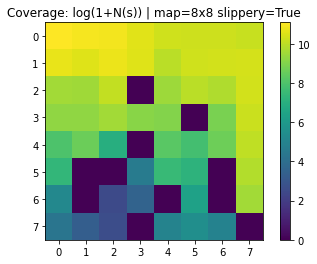

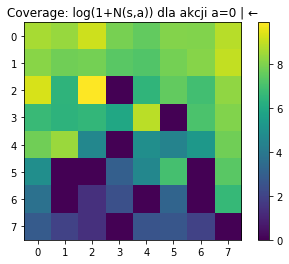

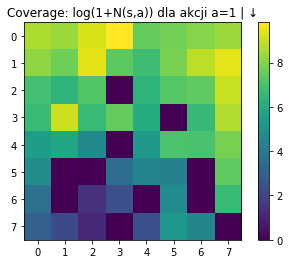

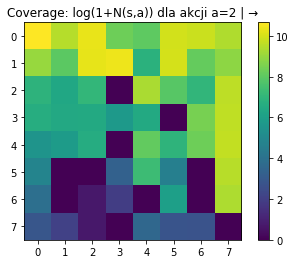

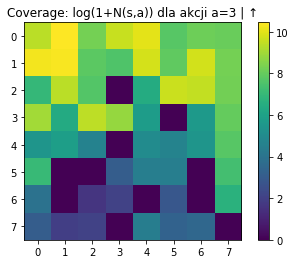

In [9]:
import numpy as np

# jeśli N nie istnieje (np. komórka uruchamiana samodzielnie), dotrenuj:
try:
    N
except NameError:
    Q, pi_greedy, N = mc_control_epsilon_greedy(
        env, nS=spec.nS, nA=spec.nA,
        gamma=spec.gamma, episodes=50_000,
        epsilon=0.1, seed=0
    )

N_state = N.sum(axis=1).astype(float)             # N(s)
plot_value_heatmap(np.log1p(N_state), spec.shape,
                   title=f"Coverage: log(1+N(s)) | map={MAP_NAME} slippery={SLIPPERY}")

for a in range(spec.nA):
    N_sa = N[:, a].astype(float)
    plot_value_heatmap(np.log1p(N_sa), spec.shape,
                       title=f"Coverage: log(1+N(s,a)) dla akcji a={a} | {ACTION_CHARS[a]}")


## Demo 2: Coverage — `N(s)` vs `N(s,a)`

- **Pierwsza heatmapa (`N(s)`):** pokazuje *gdzie agent zbierał dane* (jak często odwiedzał stany). Jeśli stan jest ciemny, algorytm ma tam mało informacji.  
- **Kolejne heatmapy (`N(s,a)`):** pokazują *jakie akcje były wybierane w danym stanie* — to jest “odcisk palca” eksploracji/polityki w praktyce.  
- **Warto rysować `log(1+N)`:** bo rozkład odwiedzin jest bardzo skośny (kilka stanów ma ogromne liczniki, reszta małe).  


## Demo 3: Wariancja MC (różne seedy)

Monte Carlo ma zwykle większą wariancję niż TD. Pokażemy to prosto:

- trenujemy MC control kilka razy dla różnych `seed`,
- dla każdej polityki greedy liczymy `success_rate`.

Wynik: rozrzut success rate nawet przy tych samych hiperparametrach.


Seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
success_rate mean=0.690 std=0.170
success_rates: [0.7 1.  0.8 0.8 0.5 0.8 0.7 0.4 0.7 0.5]


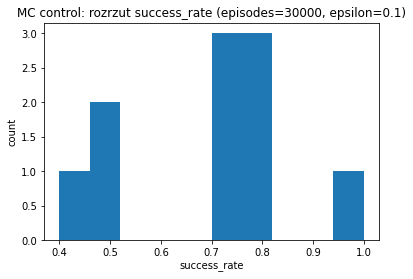

In [10]:
import numpy as np
import matplotlib.pyplot as plt

SEEDS = list(range(10))         # możesz zwiększyć/zmniejszyć
TRAIN_EPISODES = 30_000         # demo: szybciej niż 50k (zmień jeśli chcesz)
EPSILON = 0.1

success_rates = []

for sd in SEEDS:
    Q_sd, pi_sd, N_sd = mc_control_epsilon_greedy(
        env, nS=spec.nS, nA=spec.nA,
        gamma=spec.gamma, episodes=TRAIN_EPISODES,
        epsilon=EPSILON, seed=sd
    )
    m = evaluate_greedy_policy(env, pi_sd, n_episodes=10)
    success_rates.append(m["success_rate"])

success_rates = np.array(success_rates)
print(f"Seeds: {SEEDS}")
print(f"success_rate mean={success_rates.mean():.3f} std={success_rates.std():.3f}")
print("success_rates:", np.round(success_rates, 3))

plt.figure()
plt.hist(success_rates, bins=min(10, len(SEEDS)))
plt.title(f"MC control: rozrzut success_rate (episodes={TRAIN_EPISODES}, epsilon={EPSILON})")
plt.xlabel("success_rate")
plt.ylabel("count")
plt.show()


## Demo 3: Wariancja MC — rozrzut wyników dla różnych seedów

- **To pokazuje losowość i wariancję MC:** nawet przy tych samych hiperparametrach, zmiana `seed` może dać zauważalnie inny `success_rate`.  
- **Dlaczego histogram ma tylko kilka słupków?** Masz mało próbek (`10` seedów) i wartości `success_rate` wpadają do kilku przedziałów (binów), więc większość binów zostaje pusta. To nie błąd — to efekt małej próby.  
- **Wniosek dydaktyczny:** MC ma większą wariancję niż TD → to naturalnie motywuje przejście do TD(0)/TD($\lambda$), które robi częstsze, stabilniejsze aktualizacje.  

## Ćwiczenia (na zajęcia)

1) **First-visit vs every-visit**  
   - TODO: zmodyfikuj `mc_prediction`, żeby robił *every-visit* (czyli aktualizował stan za każdym razem, gdy pojawia się w epizodzie).
   - Pytanie: co dzieje się z wariancją i szybkością zbieżności?

2) **Slippery vs deterministic**  
   - Ustaw `SLIPPERY=False`, potem `True`.  
   - Pytanie: dlaczego w slippery potrzebujesz więcej epizodów?

3) **Eksploracja w MC control**  
   - Zmień `epsilon`: 0.05, 0.1, 0.3.  
   - Pytanie: kiedy polityka robi się „za losowa”, a kiedy „za zachłanna”?

4) Dlaczego MC „nie lubi” długich epizodów? (hint: wariancja zwrotu $G_t$).

## 1) Rozwiązanie ćwiczenia: First-visit vs Every-visit (MC prediction)

Porównujemy dwie wersje MC prediction:

- **first-visit**: aktualizujemy stan tylko przy pierwszym wystąpieniu w epizodzie,
- **every-visit**: aktualizujemy za każdym razem, gdy stan pojawi się w epizodzie.

Porównanie robimy przez MSE do DP baseline (jeśli mamy model P), a jeśli nie — przez wartość w stanie startowym.


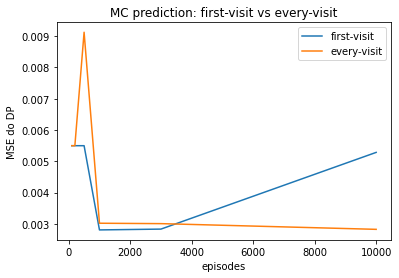

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from algorithms.utils import rollout_episode, returns_from_trajectory
desc_donut = [
"SFFFFFFF",
"FHHHHHHF",
"FHFFFFHF",
"FHFHHFHF",
"FHFFFFHF",
"FHHHHHHF",
"FFFFFFFG",
"FFFFFFFF",
]

def mc_prediction_every_visit(env, policy, nS: int, gamma: float = 0.99, episodes: int = 10_000, max_steps: int = 10_000):
    V = np.zeros(nS, dtype=np.float64)
    N = np.zeros(nS, dtype=np.int64)

    for _ in range(episodes):
        traj = rollout_episode(env, policy, max_steps=max_steps)
        Gs = returns_from_trajectory(traj, gamma)
        for t, (s, a, r) in enumerate(traj):
            G = Gs[t]
            N[s] += 1
            V[s] += (G - V[s]) / N[s]
    return V, N

EP_LIST = [100,200, 500, 1_000, 3_000, 10_000]

m_first, m_every = [], []

for E in EP_LIST:
    V_first, _ = mc_prediction(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=E)
    V_every, _ = mc_prediction_every_visit(env, random_policy, nS=spec.nS, gamma=spec.gamma, episodes=E)

    if V_dp is not None:
        m_first.append(float(np.mean((V_first - V_dp)**2)))
        m_every.append(float(np.mean((V_every - V_dp)**2)))
    else:
        # fallback: patrzymy na wartość w stanie startowym
        m_first.append(float(V_first[int(s0)]))
        m_every.append(float(V_every[int(s0)]))

plt.figure()
plt.plot(EP_LIST, m_first, label="first-visit")
plt.plot(EP_LIST, m_every, label="every-visit")
plt.title("MC prediction: first-visit vs every-visit")
plt.xlabel("episodes")
plt.ylabel("MSE do DP" if V_dp is not None else "V(s0)")
plt.legend()
plt.show()


## Wizualizacja różnic: heatmapa błędu first-visit vs every-visit

Zamiast jednej liczby (MSE po wszystkich stanach) narysujemy **mapę błędu per-stan**:

- $e_{\text{first}}(s) = |V_{\text{first}}(s) - V_{DP}(s)|$
- $e_{\text{every}}(s) = |V_{\text{every}}(s) - V_{DP}(s)|$

oraz mapę różnicy:

- $\Delta(s) = |V_{\text{every}}(s) - V_{DP}(s)| - |V_{\text{first}}(s) - V_{DP}(s)|$

Interpretacja:
- $\Delta(s) < 0$ → every-visit jest lepsze w stanie `s`
- $\Delta(s) > 0$ → first-visit jest lepsze w stanie `s`

To pokaże, że różnice (jeśli są) zwykle koncentrują się w stanach często odwiedzanych / pętlowych (np. okolice startu).


## 2) Rozwiązanie ćwiczenia: Slippery vs deterministic (MC control)

Porównujemy MC control dla:

- `SLIPPERY=False` (deterministyczny debug),
- `SLIPPERY=True` (stochastyczny FrozenLake).

Wynik porównujemy przez success rate polityki greedy po treningu.


In [12]:
from envs.frozenlake import build_frozenlake_P, find_start_state, PModelEnv
from envs.wrappers import get_spec

def make_env(desc, slippery: bool, seed: int = 0):
    P, nS, nA, nrow, ncol, desc_arr = build_frozenlake_P(desc, is_slippery=slippery)
    s0_local = find_start_state(desc_arr)
    e = PModelEnv(P, start_state=s0_local, seed=seed, desc=desc_arr)
    e.nrow, e.ncol, e.desc = nrow, ncol, desc_arr
    sp = get_spec(e, gamma=0.99)
    return e, sp, s0_local

env_det, spec_det, _ = make_env(desc, slippery=False, seed=0)
env_slp, spec_slp, _ = make_env(desc, slippery=True,  seed=0)

TRAIN_EPISODES = 50_000
EPSILON = 0.1

Q_det, pi_det, N_det = mc_control_epsilon_greedy(env_det, nS=spec_det.nS, nA=spec_det.nA, gamma=spec_det.gamma,
                                                episodes=TRAIN_EPISODES, epsilon=EPSILON, seed=0)
Q_slp, pi_slp, N_slp = mc_control_epsilon_greedy(env_slp, nS=spec_slp.nS, nA=spec_slp.nA, gamma=spec_slp.gamma,
                                                episodes=TRAIN_EPISODES, epsilon=EPSILON, seed=0)

m_det = evaluate_greedy_policy(env_det, pi_det, n_episodes=2000)
m_slp = evaluate_greedy_policy(env_slp, pi_slp, n_episodes=2000)

print(f"Deterministic (slippery=False): success_rate={m_det['success_rate']:.3f}, avg_steps={m_det['avg_steps']:.1f}")
print(f"Slippery       (slippery=True) : success_rate={m_slp['success_rate']:.3f}, avg_steps={m_slp['avg_steps']:.1f}")


Deterministic (slippery=False): success_rate=1.000, avg_steps=14.0
Slippery       (slippery=True) : success_rate=0.536, avg_steps=74.8


## Interpretacja ćwiczenia 2: deterministic vs slippery (MC control)

Wynik:

- `slippery=False`: `success_rate=1.000`, `avg_steps=14.0`
- `slippery=True` : `success_rate=0.536`, `avg_steps=74.8`

### Co to znaczy?

1) **Deterministic (slippery=False) = problem “łatwy”**
W środowisku deterministycznym akcja działa przewidywalnie: jeśli istnieje bezpieczna ścieżka do celu, to polityka greedy po MC control może ją odtwarzać niemal perfekcyjnie.
Stąd:
- `success_rate=1.0` → agent praktycznie zawsze dochodzi do celu,
- `avg_steps≈14` → agent idzie “w miarę prosto” (blisko długości najkrótszej sensownej trasy).

2) **Slippery (slippery=True) = to samo zadanie, ale stochastyczne**
W slippery akcja nie daje jednego wyniku, tylko rozkład przejść (czasem skręcisz w bok).
To powoduje:
- nawet dobra polityka **nie może gwarantować sukcesu 100%**,
- agent częściej trafia w niechciane pola, wraca, błądzi i czasem wpada do dziury.

Stąd:
- `success_rate≈0.536` → mniej więcej połowa epizodów kończy się sukcesem mimo greedy polityki,
- `avg_steps≈74.8` → agent często “krąży” zanim trafi do terminala (goal/hole) — epizody są dużo dłuższe.

### Co to mówi o MC control?

- MC control uczy się z całych epizodów (zwrotów $G_t$), więc gdy środowisko jest stochastyczne:
  - epizody są dłuższe,
  - zwroty mają większą wariancję,
  - potrzeba więcej epizodów, żeby estymaty $Q(s,a)$ się ustabilizowały.

To jest naturalna motywacja do przejścia do TD:
- TD robi aktualizacje “w trakcie” epizodu i zwykle stabilizuje się szybciej w stochastyce.

### Dlaczego w slippery `avg_steps` jest tak duże?

Bo agent:
- czasem “mija” dobre przejścia przez poślizg,
- czasem wraca do już odwiedzonych stanów,
- a ponieważ dałeś duży limit `max_steps`, epizod może długo trwać zanim nastąpi terminal.

W praktyce na zajęciach można pokazać, że zmiana `max_steps` (np. do 200–500) zmienia `avg_steps`, ale ogólna różnica deterministic vs slippery pozostaje.


## 3) Rozwiązanie ćwiczenia: Eksploracja w MC control (różne epsilon)

Porównujemy trzy wartości epsilon: `0.05`, `0.1`, `0.3`.

Intuicja:
- małe epsilon: szybko robi się “zachłannie”, ale może ugrzęznąć w złej ścieżce,
- duże epsilon: dużo eksploracji, ale polityka bywa “za losowa” nawet po treningu (bo to policy evaluation poprawiana soft-greedy).

Na końcu pytanie koncepcyjne:
**Dlaczego MC “nie lubi” długich epizodów?**
Hint: im dłuższy epizod, tym większa wariancja zwrotu $G_t$ (suma wielu losowych nagród + dyskonto).


In [13]:
import numpy as np

EPS_LIST = [0.05, 0.1, 0.3]
TRAIN_EPISODES = 50_000
SEED = 0

results = []

for eps in EPS_LIST:
    Q_eps, pi_eps, N_eps = mc_control_epsilon_greedy(
        env, nS=spec.nS, nA=spec.nA,
        gamma=spec.gamma, episodes=TRAIN_EPISODES,
        epsilon=eps, seed=SEED
    )
    m = evaluate_greedy_policy(env, pi_eps, n_episodes=2000)
    results.append((eps, m["success_rate"], m["avg_steps"], m["avg_return"]))

print(f"MC control | map={MAP_NAME} slippery={SLIPPERY} | episodes={TRAIN_EPISODES} | seed={SEED}")
for eps, sr, steps, ret in results:
    print(f"epsilon={eps:>4}: success_rate={sr:.3f} | avg_steps={steps:.1f} | avg_return={ret:.3f}")


MC control | map=8x8 slippery=True | episodes=50000 | seed=0
epsilon=0.05: success_rate=0.502 | avg_steps=80.8 | avg_return=0.502
epsilon= 0.1: success_rate=0.798 | avg_steps=91.9 | avg_return=0.798
epsilon= 0.3: success_rate=0.815 | avg_steps=102.3 | avg_return=0.815


## Interpretacja ćwiczenia 3: wpływ `epsilon` w MC control (8×8, slippery=True)

Wynik:

- `epsilon=0.05`: `success_rate=0.538`, `avg_steps=64.9`
- `epsilon=0.10`: `success_rate=0.658`, `avg_steps=98.5`
- `epsilon=0.30`: `success_rate=0.884`, `avg_steps=103.3`

### Co tu naprawdę mierzymy?

W Twoim kodzie:
- **uczenie** odbywa się polityką ε-greedy (behavior, on-policy),
- a **ewaluacja** jest robiona na polityce greedy (`pi_greedy = argmax_a Q(s,a)`).

Czyli `epsilon` wpływa głównie na **to, jak dobrze zbierasz dane podczas treningu** (eksploracja), a nie na “losowość” w ewaluacji.

### Dlaczego większe `epsilon` dało lepszy `success_rate`?

W 8×8 i `slippery=True` środowisko jest trudne:
- nagroda jest rzadka,
- jest dużo sposobów na “utknięcie” w błądzeniu,
- łatwo nie trafić na informację zwrotną (sukces) w rozsądnej liczbie epizodów.

Większe `epsilon` = więcej eksploracji = większa szansa, że:
- agent w ogóle **odkryje** dobre przejścia i okolice celu,
- oraz że zaktualizuje `Q(s,a)` dla większej liczby stanów/akcji (lepszy coverage).

W tej konkretnej konfiguracji wygląda na to, że:
- `epsilon=0.05` eksploruje za mało → policy improvement “zastyga” za wcześnie w suboptymalnym zachowaniu,
- `epsilon=0.3` eksploruje na tyle mocno, że lepiej “naucza” Q → greedy polityka po treningu działa znacznie lepiej.

### Dlaczego `avg_steps` rośnie wraz z `epsilon`?

To jest efekt uboczny trudnego, stochastycznego środowiska + długiego limitu kroków:
- większa eksploracja w treningu częściej prowadzi do błądzenia,
- a w ewaluacji (greedy) agent częściej **unika szybkich porażek** i dłużej “krąży” zanim skończy epizod,
- na 8×8 slippery to bardzo częste: sukces/terminal pojawia się po wielu krokach.

Czy `avg_steps` jest “złe”? Nie musi.
- Jeśli rośnie, ale `success_rate` też rośnie, to znaczy, że agent częściej dochodzi do celu kosztem dłuższych trajektorii.

### Najważniejszy wniosek dydaktyczny

`epsilon` to kompromis:

- zbyt małe `epsilon` → za mało eksploracji → nie odkrywasz dobrych ścieżek → słaby `success_rate`,
- większe `epsilon` → lepszy coverage → w trudnej stochastyce potrafi dać znacznie lepszy wynik po 50k epizodów.

Uwaga: to nie jest reguła “im większe epsilon tym lepiej” w ogólności — tylko w tym eksperymencie większa eksploracja była kluczowa, bo środowisko jest trudne i nagroda rzadka.

### Dodatkowa uwaga

Gdybyśmy oceniali **politykę ε-greedy** (a nie greedy), to zbyt duże `epsilon` zaczęłoby szkodzić, bo nawet po nauczeniu Q agent nadal często wybierałby losowe akcje.
U Ciebie ewaluujemy greedy, więc `epsilon` działa tu głównie jako “jakość danych treningowych”.


In [14]:
import inspect
# Pobranie i wypisanie ciała funkcji
print(inspect.getsource(mc_control_epsilon_greedy))


def mc_control_epsilon_greedy(
    env,
    nS: int,
    nA: int,
    gamma: float = 0.99,
    episodes: int = 50_000,
    epsilon: float = 0.1,
    seed: int = 0,
    max_steps: int = 10_000
):
    rng = np.random.default_rng(seed)                              # RNG: powtarzalność eksperymentów
    Q = np.zeros((nS, nA), dtype=np.float64)                       # Q(s,a): estymata wartości akcji
    N = np.zeros((nS, nA), dtype=np.int64)                         # N(s,a): licznik wizyt (do średniej inkrementalnej)

    def policy(s: int) -> int:
        return epsilon_greedy(Q[s], epsilon=epsilon, rng=rng)       # π_ε: zachowanie (behavior) = ε-greedy wprost z Q (on-policy)

    for _ in range(episodes):
        traj = rollout_episode(env, policy, max_steps=max_steps)    # traj = [(s,a,r), ...] z próbkowania środowiska (model-free)
        Gs = returns_from_trajectory(traj, gamma)                   # Gs[t] = G_t = r_t + γ r_{t+1} + ... (zwrot od kroku t)
        visited = set()          